# 04: Neutral Atom Simulator Class (Exploration)

This notebook contains an exploration towards an implementation of a neutral atom simulator.

It only covers single qubit gates, but shows them without the distraction of interactions between atoms, or more complex Python code, just focussing on the basic physics, as you might if you were exploring these things for the first time yourself.

## Imports

In [1]:
import qutip
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Exploration

We're going to need to describe the state space of our qubit, so let's start by defining some basis states for them. We'll call them `|a>` and `|b>`, but we could equally well have called them `|0>` and `|1>`.

In [3]:
# basis states |a> and |b>:

a = qutip.basis(2, 0)  # ground state
b = qutip.basis(2, 1)  # excited state

# later, for two qubit interactions, we will need a third state |r> to represent the Rydberg state.

We know we're going to need to perform operations on our qubit, so let's also define the basis elements for the space of all *operators* on a qubit. There are four basis elements, the Pauli operators $σ_x$, $σ_y$, $σ_z$, and the identity matrix:

$$ σ_x = |a〉〈b| + |b〉〈a| $$
$$ σ_y = i |a〉〈b| − i |b〉〈a| $$
$$ σ_z = |b〉〈b| − |a〉〈a| $$
$$ I = |a> <a| + |b> <b| $$

We could also have defined them using the built-in QuTiP functions such as `qutip.sigmax()`, but these definitions directly in terms of the qubit basis elements will remain correct even when we add the Rydberge state, `|r>`, and all of the basis states become qutrits.

In [4]:
# define the operators on |a> and |b>
sx = a * b.dag() + b * a.dag()
sy = 1j * a * b.dag() - 1j * b * a.dag()
sz = b * b.dag() - a * a.dag()
ii = qutip.qeye(2)

Now that we have our basis operators, we can define some pulses. A pulse is just a term in the Hamiltonian whose value depends on time. We will use square pulses, which have amplitude 0 before the start, a constant amplitude for their duration, and 0 amplitude after they end.

To represent such a time-dependent term in the Hamiltonian, we use `QobjEvo`. A `QobjEvo` consists of the operator to apply (in our case, one of `sx`, `sy` or `sz`) and a function describing the amplitude for that operator as a function of time (i.e. our square pulse).

So, for example, `QobjEvo([[sx, A]])` represents a term in the Hamiltonian that looks like $A(t) \cdot σ_x$.

In QuTiP, the function `A(t)` may also be passed additional parameters such as the duration or amplitude of the pulse. This makes it easier to adjust these values without having to write a new function `A` each time.

In [5]:
# Define a square pulse function:

def A(t, args):
    """ Square pulse from time `start` to `start + dt`.

        The parameter `theta` gives the area under the pulse, so the amplitude is `theta / dt`.
    """
    theta = args["theta"]
    start = args["start"]
    dt = args["dt"]
    # pulse goes from start to start + dt
    # amplitude = theta / dt
    amplitude = theta / dt
    if t < start:
        return 0
    if start <= t <= start + dt:
        return amplitude
    return 0

# Use the amplitude function A(t) to define some specific pulses:

H_sx = qutip.QobjEvo([[sx, A]], args={"theta": np.pi / 2, "start": 1, "dt": 1})
H_sy = qutip.QobjEvo([[sy, A]], args={"theta": np.pi / 2, "start": 1, "dt": 1})
H_sz = qutip.QobjEvo([[sz, A]], args={"theta": np.pi / 2, "start": 1, "dt": 1})

# Check that the value of H_sx is sx * A(1) when t=1:

H_sx(t=1)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.         1.57079633]
 [1.57079633 0.        ]]

We're almost ready to bring everything together, but there are a couple of things we need to do still.

First we need to define some expectation values that we'd like to record while the circuit is running. These will help us see how the quantum state is evolving and determine whether our quantum state is correct:

In [6]:
# We need to choose some expectation values to measure. We could just use the projectors
# for |a> and |b>, but let's include those for |+> and |-> too so that we can see those
# states more easily in our plots:

eop_a = a.proj()
eop_b = b.proj()
eop_p = (a + b).unit().proj()  # projector onto the plus state
eop_m = (a - b).unit().proj()  # projector onto the minus state

Secondly, we need to specify how long to evolve the system for, how often to record results (i.e. expectation values and the state of the system), and limit how big the time steps taken by the solver are allowed to get. This last is important -- if the solver takes too big a step, it might skip over a pulse entirely.

In [7]:
# Next we need to choose how long to evolve the system for each pulse.
# Our pulses are from t=1 to t=2, so let's evolve the system from time 0 to 3
# so that we can see not only the evolution during the pulse, but also the time
# immediately before and after.
# We'll arbitrarily choose to ask the solver to record the expectation values at
# intervals during the three seconds because that makes the plots look reasonably smooth:

tlist = np.linspace(0, 3, 40)

# Now for the important (!!) but boring step of specifying options to the solver. For
# time-dependent Hamiltonians we must set the max_step to a time smaller than the shortest
# pulse so that the solver does not skip over any pulses accidentally.
#
# We also specify store_states=True so that the solver will store the system state vector
# even though we will specify expectation values to store too:

options = qutip.Options(max_step=0.5, store_states=True)

Finally we're ready to apply a pulse and run `sesolve` to see what happens!

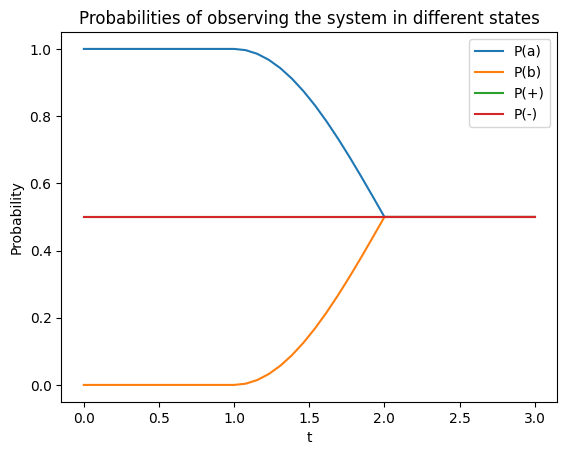

In [8]:
# Let's define the initial state psi:

psi0 = (a).unit()

# And the pulse to apply:

H = [[sx, A]]
theta = np.pi / 4

# Now we run sesovle.
# Note how we pass the angle `theta` as an argument to `sesolve`. The solver
# will then pass it on to our amplitude function, A(t).

result = qutip.sesolve(
        H, psi0, tlist,
        e_ops=[eop_a, eop_b, eop_p, eop_m],
        args={"theta": theta, "start": 1, "dt": 1},
        options=options,
    )

# And let's plot the expectation values to see what happened:

plt.plot(result.times, result.expect[0], label="P(a)");
plt.plot(result.times, result.expect[1], label="P(b)");
plt.plot(result.times, result.expect[2], label="P(+)");
plt.plot(result.times, result.expect[3], label="P(-)");
plt.legend()
plt.ylabel("Probability")
plt.xlabel("t")
plt.title("Probabilities of observing the system in different states");

We can also plot the evolution on the Bloch sphere.

We use a slightly fancy color scheme to make it look nice.
The `[(r, 0, 1-r) for r in np.linspace(0., 1., len(states))]` just says "generate a list of colours that goes from blue (`(0, 0, 1)`) to red (`(1, 0, 0)`) in a number of steps equal to the number of states (`len(states)`).

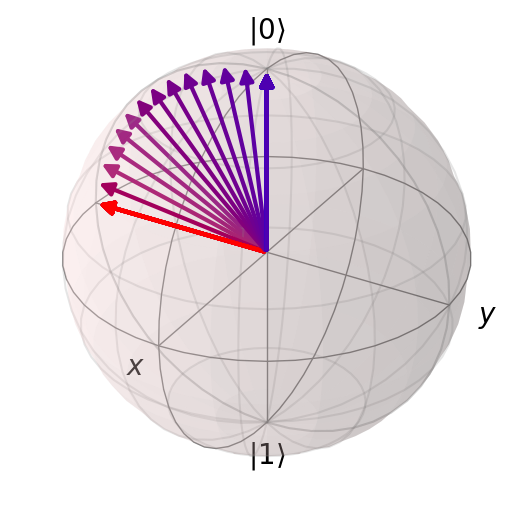

In [9]:
bl = qutip.Bloch()
bl.vector_color = [(r, 0, 1-r) for r in np.linspace(0., 1., len(result.states))]
bl.add_states(result.states)
bl.show()

Before moving on, take some time to try different pulses. Change the operator $σ_x$ to one of the other operators. Change the angle `theta`, the start time and the duration, `dt`. Take a moment to understand what happens in each case. Also change the initial state, `psi0`. Try to predict what the plot will look like before you run it.

Once you've tried lots of different parameters, you'll be ready to move on to multiple pluses in the next section.

Now that you've explored what happens with a single pulse thoroughly, it's time to run multiple pulses in succession.

We're going to use `qutip.sesolve` multiple times -- one for each pulse. At the end of each use of `qutip.sesolve`, we'll record the final state and use it as the initial state for the next pulse.

This isn't necessarily how one would code this in practice, but it is very useful for exploring and seeing what is happening.

Calling `sesolve` repeatedly means we have to gather the results. This adds some extra line of code, but they are not very complicated, just long.

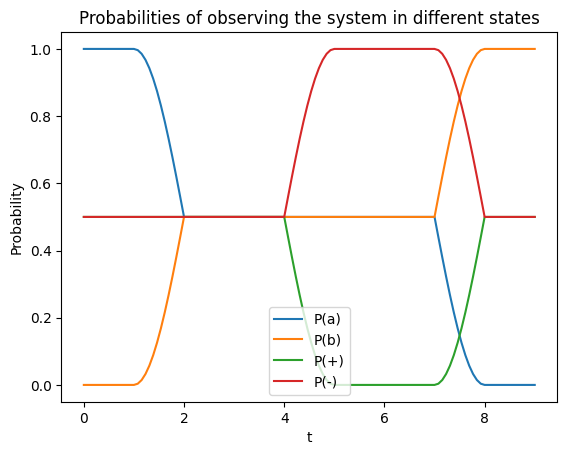

In [10]:
# As before, we define the initial state psi:

psi0 = (a).unit()

# Now we specify multiply gates to run in a list:

gates = [
    (H_sx, np.pi / 4),
    (H_sz, np.pi / 4),
    (H_sy, np.pi / 4),
]

# Everything is setup, now all that remains is to run sesolve for each pulse:
# For each gate, run sesolve and store the results.
# We store all the results in a list named `results`.

results = []

for H, theta in gates:
    # Run sesovle.
    # Note how we pass the angle `theta` as an argument to `sesolve`. The solver
    # will then pass it on to our amplitude function, A(t).
    result = qutip.sesolve(
        H, psi0, tlist,
        e_ops=[eop_a, eop_b, eop_p, eop_m],
        args={"theta": theta},
        options=options,
    )

    # set the initial state for the next gate to the final state of this one
    psi0 = result.states[-1]

    # store the results for plotting
    results.append(result)

# Now we gather up the results for plottng.
# Gathering the times is a bit more tricky because we have to adjust them according to the pulse
# start time:

expect_a = []
expect_b = []
expect_p = []
expect_m = []
states = []
times = []

start = 0
for r in results:
    expect_a.extend(r.expect[0])
    expect_b.extend(r.expect[1])
    expect_p.extend(r.expect[2])
    expect_m.extend(r.expect[3])
    states.extend(r.states)
    times.extend(t + start for t in r.times)
    start += 3  # each solver run was for three seconds

# And let's plot the expectation values to see what happened:

plt.plot(times, expect_a, label="P(a)");
plt.plot(times, expect_b, label="P(b)");
plt.plot(times, expect_p, label="P(+)");
plt.plot(times, expect_m, label="P(-)");
plt.legend()
plt.ylabel("Probability")
plt.xlabel("t")
plt.title("Probabilities of observing the system in different states");

And we can also plot the evolution over all pulses on the Bloch sphere, using the same color scheme as before:

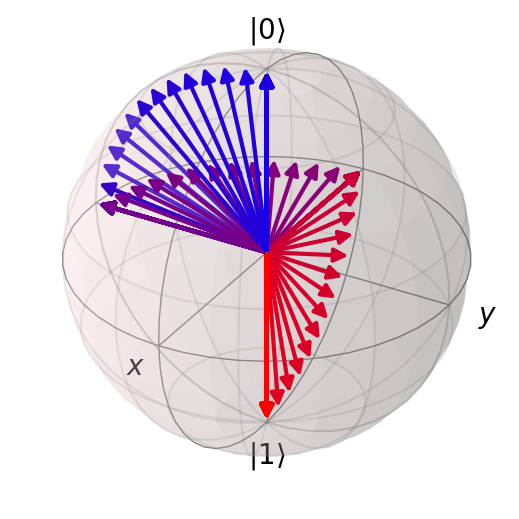

In [11]:
bl = qutip.Bloch()
bl.vector_color = [(r, 0, 1-r) for r in np.linspace(0., 1., len(states))]
bl.add_states(states)
bl.show()